# Modelling of Atmospheric Clodus
#### copyright: Jagiellonian University   
#### licence: CC-BY
#### author: Sylwester Arabas

## Class 4 (March 16, virtual)

Let's try to reproduce Figure 7.4 from Rogers & Yau 
(first and last panel this week, middle panels next week)

![alt text](Rogers_Yau_Fig_7.4.png "Rogers_Yau_Fig_7.4")

### previously on...

In [1]:
import numpy as np
import pint
from matplotlib import pyplot
si = pint.UnitRegistry()
si.setup_matplotlib()

In [2]:
class Constants:
    from scipy import constants
    import mendeleev as pt
    
    # polynomial fot to equilibrium vapour pressure wrt water (coefficients from Flatau et al. 1992)
    # doi:10.1175/1520-0450(1992)031<1507%3APFTSVP>2.0.CO%3B2
    c_w = (6.115836990e000, 0.444606896e000, 0.143177157e-01, 0.264224321e-03, 0.299291081e-05,
           0.203154182e-07, 0.702620698e-10, 0.379534310e-13, -.321582393e-15)
    
    T0 = T0 = constants.zero_Celsius * si.kelvin
    
    def __molar_mass(x):
        return x.atomic_weight * si.gram / si.mole

    M_a = (
        0.78 * __molar_mass(pt.N) * 2 + 
        0.21 * __molar_mass(pt.O) * 2 + 
        0.01 * __molar_mass(pt.Ar)
    )
    M_v = __molar_mass(pt.O) + __molar_mass(pt.H) * 2
    
    R_str = constants.R * si.joule / si.kelvin / si.mole
    
    R_a = R_str / M_a
    R_v = R_str / M_v
    
    g = constants.g * si.metre / si.second**2
    
    # the only new things!
    l_v = 2.5e6 * si.joule / si.kilogram
    c_p  = 1000 * si.joule / si.kilogram / si.kelvin

In [3]:
class Formulae:
    @staticmethod
    def rho(p, R, T):
        return p / (R * T)

    @staticmethod
    def __p_sat(temperature, coefficients, valid_range):
        from numpy.polynomial.polynomial import polyval

        value = polyval(temperature.to(si.celsius).magnitude, coefficients)

        if isinstance(temperature.magnitude, np.ndarray):
            value[np.logical_or(temperature < valid_range[0], temperature > valid_range[1])] = np.nan
        else:
            value = np.nan if not valid_range[0] < temperature <= valid_range[1] else value

        return value * si.hectopascals    

    @staticmethod
    def p_eq(T):
        return Formulae.__p_sat(T, Constants.c_w, (Constants.T0-85 * si.kelvin, np.inf * si.kelvin))

### let's play with numpy, pint and scipy

In [4]:
class Storage:
    class __Impl(np.ndarray):
        p_idx, p_unit = 0, si.hectopascals
        T_idx, T_unit = 1, si.kelvins
        m_idx, m_unit = 2, si.grams
        z_unit = si.metres
        
        @property
        def p(self):
            return self[self.p_idx] * self.p_unit

        @p.setter
        def p(self, value):
            self[self.p_idx] = value.to(self.p_unit) / self.p_unit

        @property
        def T(self):
            return self[self.T_idx] * self.T_unit

        @T.setter
        def T(self, value):
            self[self.T_idx] = value.to(self.T_unit) / self.T_unit

        @property
        def m(self):
            return self[self.m_idx] * self.m_unit

        @m.setter
        def m(self, value):
            self[self.m_idx] = value.to(self.m_unit) / self.m_unit

    @staticmethod
    def __make_storage(shape):
        storage = Storage.__Impl(shape)
        return storage
    
    @staticmethod
    def make_state():
        return Storage.__make_storage((3,))

    @staticmethod
    def make_deriv(state):
        storage = Storage.__make_storage(state.shape)
        storage.p_unit /= storage.z_unit
        storage.T_unit /= storage.z_unit
        storage.m_unit /= storage.z_unit
        return storage
    
    @staticmethod
    def view_state(array):
        storage = Storage.__make_storage(array.shape)
        storage[:] = array[:]
        return storage

### the system we need to solve (super simplified "parcel model")

$$
\begin{eqnarray}
  \frac{dp}{dz} &=& - \rho g \\
  \frac{dm}{dz} &=& \frac{\max(0, m_v - m_{eq})}{dz} \\
  \frac{dT}{dz} &=& \frac{1}{c_p} \left(\frac{1}{\rho}\frac{dp}{dz} + \frac{l_v}{m_a} \frac{dm}{dz} \right)
\end{eqnarray}
$$

$p$: pressure   
$z$: vertical displacement   
$\rho$: density   
$g$: gravitational acceleration   
$m$: mass of liquid water   
$m_v$: mass of water vapour      
$m_{eq}$: mass of water vapour at saturation (in phase equilibrium wrt water surface)   
$T$: temperature   
$c_p$: specific heat of air   
$l_v$: latent heat of vapourisation   
$m_a$: mass of air

### let's implement the system according to SciPy API

In [5]:
class System:
    def __init__(self, pv0, volume, state):
        assert state.m == 0
        self.m_a = Formulae.rho(state.p, Constants.R_a, state.T) * volume
        self.m_w = Formulae.rho(pv0, Constants.R_v, state.T) * volume
        
    def __call__(self, _, state, dz):
        state = Storage.view_state(state)
        deriv = Storage.make_deriv(state)
            
        rho = Formulae.rho(state.p, Constants.R_a, state.T)
        volume = self.m_a / rho
        p_eq = Formulae.p_eq(state.T)
        m_eq = Formulae.rho(p_eq, Constants.R_v, state.T) * volume
        m_v = self.m_w - state.m
        
        # hydrostatic pressure
        deriv.p = -Formulae.rho(state.p, Constants.R_a, state.T) * Constants.g
        
        # saturation adjustment
        deriv.m = max(0 * state.m_unit, m_v - m_eq) / dz
            
        # heat budget
        deriv.T = (deriv.p/rho + deriv.m/self.m_a * Constants.l_v) / Constants.c_p
        
        return deriv

### before using sophisticated solvers from SciPy (next week), let's use a simplest one 

In [6]:
def solve(system, state, displacement, dz):
    nz = int(displacement / dz)
    z = [0.] * nz * state.z_unit
    states = np.repeat(state.reshape(-1, 1), nz, axis=1)
    dz_magn = dz.to(state.z_unit).magnitude
    
    for i, _ in enumerate(z[1:], start=1):
        z[i] = z[i-1] + dz
        states[:, i] = states[:, i-1] + dz_magn * system(_, states[:, i-1], dz)
        
    return states, z

### and let's finally do the calculations ...

In [25]:
state = Storage.make_state()

state.p = 1000 * si.hectopascals 
state.T = 300 * si.kelvins
state.m = 0 * si.grams

volume = 1 * si.metre**3
pv0 = .995 * Formulae.p_eq(state.T)
displacement = 100 * si.metres

system = System(pv0, volume, state)
integ, z = solve(system, state, displacement, dz = .1 * si.metre)

### ... and plotting

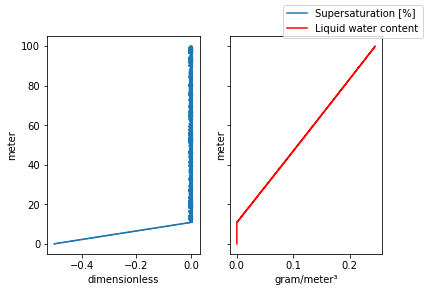

In [28]:
m_v = system.m_w - integ.m
volume = system.m_a / Formulae.rho(integ.p, Constants.R_a, integ.T) 
p_v = m_v / volume * Constants.R_v * integ.T
p_eq = Formulae.p_eq(integ.T)

fig, axs = pyplot.subplots(1, 2, sharey=True)
axs[0].step(100 * (p_v / p_eq - 1), z, label='Supersaturation [%]')
axs[1].step(integ.m / volume, z, color='red', label='Liquid water content')
fig.legend()

## TBC!